SentenceClassification with LSTM

## Import package

In [ ]:
!pip install attacut
from attacut import tokenize
import gdown
import tensorflow as tf
from tensorflow import keras
import numpy as np
import re
import pandas as pd
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Dataset & Data preprocessing

In [ ]:
df = pd.read_csv('NLP_Project_dataset2.csv')
df = df.filter(['sentence','label'], axis=1)
df.head()

,sentence,label
0,ขอสเปกและราคาของโน๊ตบุ๊ครุ่นนี้หน่อยได้ไหมครับ,0
1,หาข้อมูลของโน๊ตบุ๊ครุ่นนี้ได้ที่ไหนบ้างครับ,0
2,แจ้งรายละเอียดของโน๊ตบุ๊ครุ่นนี้หน่อยครับ,0
3,ขอคำแนะนำเกี่ยวกับโน๊ตบุ๊ครุ่นนี้หน่อยครับ,0
4,ขอรายละเอียดของสเปกของโน๊ตบุ๊ครุ่นนี้หน่อยครับ,0


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify = df['label'])
df_train, df_val = train_test_split(df_train, test_size=0.25, stratify = df_train['label'])
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(390, 2)
(130, 2)
(130, 2)


In [ ]:
Xtrain = df_train['sentence'].values.tolist()
print(Xtrain)

Ytrain = df_train['label'].values.tolist()
print(Ytrain)

Xval = df_val['sentence'].values.tolist()
print(Xval)

Yval = df_val['label'].values.tolist()
print(Yval)

Xtest = df_test['sentence'].values.tolist()
print(Xtest)

Ytest = df_test['label'].values.tolist()
print(Ytest)

['ว่าไงครับ', 'อยากได้ที่คีย์บอร์ดมีไฟ ปรับไฟได้ เล่นเกมส์ได้ลื่นๆ', 'แล็ปท็อปเล็กๆ พกพาง่าย', 'แล็ปท็อปเบาๆ', 'วันศุกร์ไปไหนมั้ยครับ', 'มีรุ่นไหนอบผ้าได้มั้ยคะ', 'คอมพิวเตอร์ทำงานราคาไม่แรง', 'เพลงฮิตตอนนี้มีอะไรบ้าง', 'น้ำหนักเบา สีดำ ใช้พิมพ์งานเฉยๆ ราคาไม่แรง', 'คอมที่มีหน้าจอ 21 นิ้ว, การ์ดจอ Intel 50,000 บาท', 'MSI GL series มีสีอะไรบ้าง', 'อยากกิน Macfish', 'แล็ปท็อปพิมพ์งาน ประชุมงาน พนักงานออฟฟิศ', 'ไฟแต่งห้องเปลี่ยนสีได้', 'ACER ที่ทนๆ มีประกันนานๆ', 'ร่มคันสีน้ำตาลอมม่วง', 'ทำ dataset กำกวมไปมั้ยนะ', 'สุขสันต์วันครบรอบ', 'คอมพิวเตอร์พิมพ์งาน', 'เลือกคอมที่คิดว่าดีที่สุดมาแนะนำ', 'มีปลอกคอสุนัขขายมั้ยคะ', 'อาหาร Macdonal อร่อย', 'Macbook สีขาวตัวถูกสุด', 'คีย์บอร์ดไร้สาย มีไฟ มีเสียง', 'ว่างมากๆวันนี้ เล่าเรื่องตลกมาได้เลยจ้า', 'ไงคะ', 'อยากทราบราคาข้าวหมูเกาหลี', 'Acer รุ่นไหนเสียงดีบ้างนะ', 'Msi สีดำ เล่นเกม ทรงเกมมิ่ง', 'ร้านนี้มีสินค้าที่น่าสนใจมากๆเลย', 'มันจะหลากหลายมั้ยนะ', 'เสื้อลายการ์ตูน', 'อยากทราบวิธีทำไข่เจียว', 'โน๊ตบุ๊คสำหรับโปรแกรมเมอร์', 'MSI สีดำ เสียงพัดลมเ

## Tokenize & Word Embbeding

In [ ]:
gdown.download('https://drive.google.com/uc?id=0B0ZXk88koS2KV1FJN0xRX1FxaFE&export=download', 'th.zip', quiet=False) 


Downloading...
From: https://drive.google.com/uc?id=0B0ZXk88koS2KV1FJN0xRX1FxaFE&export=download
To: /content/th.zip
100%|██████████| 122M/122M [00:02<00:00, 53.9MB/s]


'th.zip'

In [ ]:
!unzip th.zip

Archive:  th.zip
  inflating: th.bin                  
  inflating: th.tsv                  


In [ ]:
with open('th.tsv') as f:
  vocab = []
  W = None
  vec = ''
  for line in f.readlines():
    temp = line.split('\t')
    if len(temp) == 3:
      vocab.append(temp[1])
      if int(temp[0]) % 1000 == 0:
        print('\r' + temp[0], end='')
      wordvector = np.fromstring(re.sub('\s+', ' ', vec)[1:-1], sep=' ', dtype=np.float32)
      if len(wordvector) > 0:
        if W is None:
          W = wordvector.copy()
        else:
          W = np.vstack((W, wordvector))
      vec = temp[-1]
    elif len(temp) == 1:
      vec += temp[-1]
  W = np.vstack((W, wordvector))
print('\n')
print(len(vocab))
print(W.shape)

0

<ipython-input-11-dc2ff50a1690>:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  wordvector = np.fromstring(re.sub('\s+', ' ', vec)[1:-1], sep=' ', dtype=np.float32)


30000

30225
(30225, 300)


In [ ]:
vocab = [''] + vocab
print(len(vocab))

30226


In [ ]:
W = np.vstack((np.random.rand(*W[0].shape), W))

In [ ]:
W.shape

(30226, 300)

In [ ]:
def sent2idx(x):
  xidx = []
  for w in tokenize(x):
    if w in vocab:
      xidx.append(vocab.index(w))
  return np.array(xidx)

In [ ]:
Xtrain_idx = []
maxlen = 0
for x in Xtrain:
  Xtrain_idx.append(sent2idx(x))
  if len(Xtrain_idx[-1]) > maxlen:
    maxlen = len(Xtrain_idx[-1])
  # print(len(Xtrain_idx[-1]))

In [ ]:
Xtrain_idx

[array([  15, 6079,  346]),
 array([ 806,    8,    0, 3746,    7,  610,  786,  610,    8,  194, 1032,
           8, 6859,   94]),
 array([16368,   382,    94]),
 array([16368,  2468,    94]),
 array([  28, 1678,   17, 1363, 7526,  346]),
 array([   7,  246,  936,    8, 7526, 1003]),
 array([ 905,   67,   61, 1040,   20,  566]),
 array([  69, 2604,  135,   23,    7,  718,  978]),
 array([1046, 2468,   96,  569,   26,  539,   61, 5963,   94, 1040,   20,
         566]),
 array([1179,    0,    7,  159, 1457, 1241,  282]),
 array([  7,  96, 718, 978]),
 array([806, 555]),
 array([ 850,   61, 1842, 6475]),
 array([610, 560, 355, 235,  96,   8]),
 array([   0, 2564,   94,    7, 2819,  510,   94]),
 array([2921,  988,   96, 1899, 1624, 1508]),
 array([  67, 5938,   17, 7526,  430]),
 array([  28, 1089,  185]),
 array([61]),
 array([ 469, 1179,    0,  463,   15,   77,  138,   10, 1190]),
 array([   7, 7131,  632, 2215,  503, 7526, 1003]),
 array([ 337, 6344]),
 array([ 96, 521,  42,  57, 230]),

In [ ]:
for i, x in enumerate(Xtrain_idx):
  if len(x) < maxlen:
    Xtrain_idx[i] = np.hstack((x, np.zeros(maxlen-len(x))))
Xtrain_idx = np.array(Xtrain_idx)

In [ ]:
Xtrain_idx.shape

(390, 19)

In [ ]:
Xval_idx = []
maxlen = 0
for x in Xval:
  Xval_idx.append(sent2idx(x))
  if len(Xval_idx[-1]) > maxlen:
    maxlen = len(Xval_idx[-1])
  # print(len(Xval_idx[-1]))

for i, x in enumerate(Xval_idx):
  if len(x) < maxlen:
    Xval_idx[i] = np.hstack((x, np.zeros(maxlen-len(x))))
Xval_idx = np.array(Xval_idx)

In [ ]:
Xval_idx.shape

(130, 19)

## Model Buiding

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(W.shape[0], W.shape[1], name='embed'))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(8, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(4)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(2))

model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=1e-4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed (Embedding)           (None, None, 300)         9067800   
                                                                 
 bidirectional (Bidirectiona  (None, None, 16)         19776     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 8)                672       
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9,088,954
Trainable params: 9,088,954
Non-

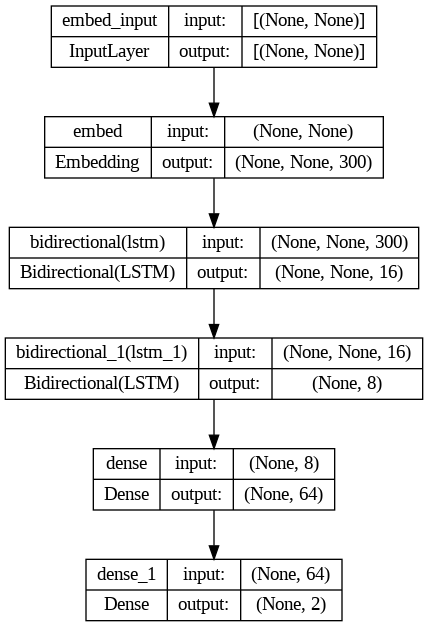

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.get_layer('embed').set_weights([W])
model.get_layer('embed').trainable = False

In [ ]:
model.fit(Xtrain_idx, np.array(Ytrain), epochs=100,validation_data=(Xval_idx, np.array(Yval)))

Epoch 1/100
13/13 [==============================] - 13s 206ms/step - loss: 1.8821 - val_loss: 0.8474
Epoch 2/100
13/13 [==============================] - 1s 71ms/step - loss: 0.7442 - val_loss: 0.8463
Epoch 3/100
13/13 [==============================] - 1s 79ms/step - loss: 0.7441 - val_loss: 0.8451
Epoch 4/100
13/13 [==============================] - 1s 58ms/step - loss: 0.7439 - val_loss: 0.8436
Epoch 5/100
13/13 [==============================] - 1s 64ms/step - loss: 0.7438 - val_loss: 0.8417
Epoch 6/100
13/13 [==============================] - 1s 47ms/step - loss: 0.7436 - val_loss: 0.8445
Epoch 7/100
13/13 [==============================] - 1s 42ms/step - loss: 0.7435 - val_loss: 0.8422
Epoch 8/100
13/13 [==============================] - 0s 34ms/step - loss: 0.7437 - val_loss: 0.8452
Epoch 9/100
13/13 [==============================] - 0s 21ms/step - loss: 0.7435 - val_loss: 0.8418
Epoch 10/100
13/13 [==============================] - 0s 30ms/step - loss: 0.7433 - val_loss: 0.83

## Model result

### Train Result

In [ ]:
Ypred_train = model.predict(Xtrain_idx).argmax(axis=1)
Ytrue_train= np.array(Ytrain)

13/13 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Request', 'Neutral']
print(classification_report(Ytrue_train, Ypred_train, target_names=target_names))

              precision    recall  f1-score   support

     Request       0.44      0.63      0.52       180
     Neutral       0.51      0.33      0.40       210

    accuracy                           0.47       390
   macro avg       0.48      0.48      0.46       390
weighted avg       0.48      0.47      0.46       390



### Test Result

In [ ]:
Xtest_idx = []
for x in Xtest:
  Xtest_idx.append(sent2idx(x))
  if len(Xtest_idx[-1]) > maxlen:
    Xtest_idx[-1] =  Xtest_idx[-1][:maxlen]
  else:
    Xtest_idx[-1] = np.hstack((Xtest_idx[-1], np.zeros(maxlen-len(Xtest_idx[-1]))))
Xtest_idx = np.array(Xtest_idx)

In [ ]:
Ypred_test = model.predict(Xtest_idx).argmax(axis=1)
Ytrue_test= np.array(Ytest)

5/5 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Request', 'Neutral']
print(classification_report(Ytrue_test, Ypred_test, target_names=target_names))

              precision    recall  f1-score   support

     Request       0.57      0.87      0.68        60
     Neutral       0.79      0.43      0.56        70

    accuracy                           0.63       130
   macro avg       0.68      0.65      0.62       130
weighted avg       0.69      0.63      0.61       130



## Demo

In [ ]:
output_class = {0:'Request', 1:'Neutral'}

testWord = ['แนะนำโน๊ตบุ๊คที่มีแบตอึดและเร็วหน่อยได้ไหมครับ']
testWord_idx = []
for x in testWord:
  testWord_idx.append(sent2idx(x))
  if len(testWord_idx[-1]) > maxlen:
    testWord_idx[-1] =  testWord_idx[-1][:maxlen]
  else:
    testWord_idx[-1] = np.hstack((testWord_idx[-1], np.zeros(maxlen-len(testWord_idx[-1]))))
testWord_idx = np.array(testWord_idx)

pred = model.predict(testWord_idx).argmax(axis=1)

print(testWord)
print('sentence class: ',output_class[pred[0]])

1/1 [==============================] - 0s 23ms/step
['แนะนำโน๊ตบุ๊คที่มีแบตอึดและเร็วหน่อยได้ไหมครับ']
sentence class:  Request


In [ ]:
testWord = ['อาจารย์ปอน่ารัก']
testWord_idx = []
for x in testWord:
  testWord_idx.append(sent2idx(x))
  if len(testWord_idx[-1]) > maxlen:
    testWord_idx[-1] =  testWord_idx[-1][:maxlen]
  else:
    testWord_idx[-1] = np.hstack((testWord_idx[-1], np.zeros(maxlen-len(testWord_idx[-1]))))
testWord_idx = np.array(testWord_idx)

pred = model.predict(testWord_idx).argmax(axis=1)

print(testWord)
print('sentence class: ',output_class[pred[0]])


1/1 [==============================] - 0s 20ms/step
['อาจารย์ปอน่ารัก']
sentence class:  Neutral
